# Deploy Pre-train YOLO People-detection Model (to detect players) Using MXNet

### Building an image detection server with gluoncv
In this notebook, we deploy a pre-trained image detection model
 1. We first import a model from the gluon model zoo locally on the notebook, that we then compress and send to S3
 1. We then use the SageMaker MXNet Serving feature to deploy the model to a real-time managed endpoint. It uses the model artifact that we previously loaded to S3.
 1. We query the endpoint and visualize detection results


* **More on `gluon` and `gluoncv`:**
 * [gluon](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/index.html)** is the imperative python front-end of the Apache MXNet deep learning framework. Gluon notably features specialized toolkits helping reproducing state-of-the-art architectures: [gluon-cv](https://gluon-cv.mxnet.io/), [gluon-nlp](https://gluon-nlp.mxnet.io/), [gluon-ts](https://gluon-ts.mxnet.io/). Gluon also features a number of excellent end-to-end tutorial mixing science with code such as [D2L.ai](https://classic.d2l.ai/) and [The Straight Dope](https://gluon.mxnet.io/)
 * [gluoncv](https://gluon-cv.mxnet.io/contents.html) is an efficient computer vision toolkit written on top of `gluon` and MXNet aiming to make state-of-the-art vision research reproducible. 

* This specific demo has been developed on the `conda_mxnet_p36` kernel of a SageMaker `ml.c5.2xlarge` Notebook instance

**This sample is provided for demonstration purposes, make sure to conduct appropriate testing if derivating this code for your own use-cases!**

In [1]:
! pip install gluoncv=='0.6.0'

     |████████████████████████████████| 693 kB 18.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import datetime
import json
import math
import os
import shutil
import subprocess as sb
import tarfile

import boto3
import gluoncv
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon, image, nd

# import SageMaker tools
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet.model import MXNetModel

## Import a pre-trained detection model, locally
gluon model zoo https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html contains a variety of models.
In this demo we use a YoloV3 detection model (Redmon et Farhadi). More about YoloV3:
* paper https://pjreddie.com/media/files/papers/YOLOv3.pdf
* Website https://pjreddie.com/darknet/yolo/

Gluoncv model zoo contains a number of architectures with different performances in terms of speed and accuracy. If you are looking for speed or accuracy, don't hesitate to change the model

In [3]:
model_name = 'yolo3_darknet53_coco'
net = model_zoo.get_model(model_name, pretrained=True)

100%|██████████| 224190/224190 [00:06<00:00, 32480.75KB/s]


The model we downloaded above is trained on the COCO dataset and can detect 80 classes. In this demo, we restrict the model to detect only specific classes of interest.
This idea is derived from the official gluoncv tutorial: https://gluon-cv.mxnet.io/build/examples_detection/skip_fintune.html


COCO contains the following classes:

In [4]:
print('coco classes: ', net.classes)

coco classes:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [5]:
# in this demo we reset the detector to the "person" class

classes = ['person']

net.reset_class(classes=classes, reuse_weights=classes)
print('new classes: ', net.classes)

net.hybridize()  # hybridize to optimize computation

new classes:  ['person']


## Show detection results through each image in the folder

Text(0.5, 1.0, 'FrameTest')

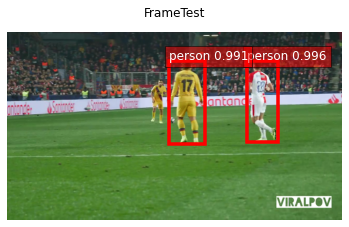

In [12]:
import cv2
import os

# images folder for detection
frames_folder = "Messi vs Slavia Praha (MESSI CAM) Frames/clip4_Frames"
fnames = os.listdir(frames_folder)

# looping image file in the folder
for i,frame in enumerate(fnames):
    print("frame {}".format(i))
    
    # if the file is an jpg image
    if fnames[i].lower().endswith('.jpeg') or fnames[i].lower().endswith('.jpg'):
        im_array =  image.imread(os.path.join(frames_folder, fnames[i]))
        x, orig_img = data.transforms.presets.yolo.transform_test(im_array)
        
        # forward pass and display
        box_ids, scores, bboxes = net(x)
        ax = utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=classes, thresh=0.9)
        ax.axis("off")
        ax.set_title(fnames[i], pad=15)

    else:
        print("not a jpeg image")
        continue
    
print("enumerate frames complete")



### Crop and save all detected player image for incremental training for number recognition

In [138]:
def crop_and_save(bboxes,img,folder,frame,c):
    from datetime import datetime
    # datetime object containing current date and time
    now = datetime.now()
    dt_string = now.strftime("%d_%m")
    
    framename = os.path.splitext(frame)[0]
    
    # read bbox
    x0,y0,x1,y1 = bbox =  bboxes[0][c].astype(int).asnumpy()
    h = y1-y0
    w = x1-x0
    cropped = img[y0:y0+h , x0:x0+w, :]

    try:
        # save cropped imag
        img = plt.imshow(cropped, interpolation='nearest')
        img.set_cmap('hot')
        plt.axis('off')
        plt.savefig(os.path.join(folder,(('{}_{}_{}.jpg'.format(framename,c,dt_string)))), bbox_inches='tight')
        plt.close()
    except ValueError:  #raised if `y` is empty.
        pass

In [143]:
import cv2
import os

# create detection output folder
frames_folder = "Messi vs Slavia Praha (MESSI CAM) Frames/clip4_Frames"
fnames = os.listdir(frames_folder)

crop_output_dir = "Messi_Players_Unselected/clip4_players"
if not os.path.exists(crop_output_dir):
    os.mkdir(crop_output_dir)
print("created cropped detection directory {}".format(crop_output_dir))

# looping image file in the folder
for i,frame in enumerate(fnames):
    print("frame {}".format(i))
    
    if fnames[i].lower().endswith('.jpeg') or fnames[i].lower().endswith('.jpg'):
        im_array =  image.imread(os.path.join(frames_folder, fnames[i]))
        x, orig_img = data.transforms.presets.yolo.transform_test(im_array)

        box_ids, scores, bboxes = net(x)
        
        scores_list = scores[0].astype(float).asnumpy().tolist()
        crop_count = 0
        
        for j in (scores_list):
            if j[0] < 0.9:
                break
            crop_count = crop_count+1
            crop_and_save(bboxes,orig_img,crop_output_dir,fnames[i],crop_count)   
        print("cropped {} detection in {}".format(crop_count,frame))
   

    else:
        print("not a jpeg image")
        continue
    
print("enumerate frames complete")


created cropped detection directory Messi_Players_Unselected/clip4_players
frame 0
cropped 5 detection in clip4_frame105.jpg
frame 1
cropped 6 detection in clip4_frame10.jpg
frame 2
cropped 8 detection in clip4_frame40.jpg
frame 3
cropped 4 detection in clip4_frame90.jpg
frame 4
cropped 6 detection in clip4_frame15.jpg
frame 5
cropped 5 detection in clip4_frame80.jpg
frame 6
cropped 4 detection in clip4_frame50.jpg
frame 7
cropped 5 detection in clip4_frame140.jpg
frame 8
cropped 5 detection in clip4_frame145.jpg
frame 9
not a jpeg image
frame 10
cropped 6 detection in clip4_frame55.jpg
frame 11
cropped 8 detection in clip4_frame60.jpg
frame 12
cropped 3 detection in clip4_frame5.jpg
frame 13
cropped 5 detection in clip4_frame160.jpg
frame 14
cropped 6 detection in clip4_frame25.jpg
frame 15
cropped 4 detection in clip4_frame95.jpg
frame 16
cropped 6 detection in clip4_frame45.jpg
frame 17
cropped 5 detection in clip4_frame135.jpg
frame 18
cropped 5 detection in clip4_frame75.jpg
frame